In [1]:
import os
import librosa
import random
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import tqdm as tqdm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning as L
import torchmetrics
from sklearn.metrics import f1_score, accuracy_score
import torch.nn.utils.prune as prune

import time

import torch
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [14]:
import matplotlib
import sklearn
import sys

print('librosa',librosa.__version__)
print('torch',torch.__version__)
print('numpy',np.__version__)
print('tqdm',tqdm.__version__)
print('lightning',L.__version__)
print('torchmetrics',torchmetrics.__version__)
print('sklearn',sklearn.__version__)
print("Python {}.{}".format(sys.version_info.major,sys.version_info.minor))

librosa 0.10.1
torch 2.0.1+cu118
numpy 1.24.1
tqdm 4.66.1
lightning 2.2.2
torchmetrics 1.3.2
sklearn 1.3.2
Python 3.11


In [2]:
#dataset
class Audio_dataset(Dataset):
    def __init__(self, dir_path, dataset_sampling_rate, anomaly_dir_path = None, anomaly_ratio = None,transform=None, target_transform=None):
        # self.dataset_sampling_rate = 22050
        self.dir_path = dir_path
        self.dataset_sampling_rate = dataset_sampling_rate
        self.transform = transform
        self.target_transform = target_transform
        self.file_names = os.listdir(self.dir_path)
        self.last_idx = len(self.file_names)

        self.anomaly_recorded_path_dir =r"datasets\anomalies\nagrane"
        self.anomaly_recorded_file_names = os.listdir(self.anomaly_recorded_path_dir)
        self.anomaly_speech_path_dir =r"datasets\kaggle\LJ_Speech_dataset\archive\LJSpeech-1.1\wavs"
        self.anomaly_speech_file_names = os.listdir(self.anomaly_speech_path_dir)

        self.anomaly_uderzenie_path = r"datasets\anomalies\nagrane_podzielone\uderzenie"
        self.anomaly_uderzenie_file_names = os.listdir(self.anomaly_uderzenie_path)
        self.anomaly_dmuchniecie_path = r"datasets\anomalies\nagrane_podzielone\dmuchniecie"
        self.anomaly_dmuchniecie_file_names = os.listdir(self.anomaly_dmuchniecie_path)
        self.anomaly_losowe_path = r"datasets\anomalies\nagrane_podzielone\losowe"
        self.anomaly_losowe_file_names = os.listdir(self.anomaly_losowe_path)

        self.lables = {
            0:torch.tensor([1,0,0,0,0], dtype=torch.float32),
            1:torch.tensor([0,1,0,0,0], dtype=torch.float32),
            2:torch.tensor([0,0,1,0,0], dtype=torch.float32),
            3:torch.tensor([0,0,0,1,0], dtype=torch.float32),
            4:torch.tensor([0,0,0,0,1], dtype=torch.float32),
            torch.tensor([1,0,0,0,0], dtype=torch.float32):0,
            torch.tensor([0,1,0,0,0], dtype=torch.float32):1,
            torch.tensor([0,0,1,0,0], dtype=torch.float32):2,
            torch.tensor([0,0,0,1,0], dtype=torch.float32):3,
            torch.tensor([0,0,0,0,1], dtype=torch.float32):4,
        }

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        anomaly_type = random.sample((0,1,2,3,4),2)
        data, sr, cqt_1 = self.pipeline(idx, anomaly_type=anomaly_type[0])
        _, _, cqt_2 = self.pipeline(random.randint(0, self.last_idx - 1), anomaly_type=anomaly_type[1])
        _, _, anchor = self.pipeline(random.randint(0, self.last_idx - 1), anomaly_type=anomaly_type[0])
        label1 = self.lables[anomaly_type[0]]
        label2 = self.lables[anomaly_type[1]]

        return anchor, cqt_1, cqt_2, label1, label2, data, sr

    def make_cqt(self, data):
        C = librosa.cqt(data, sr=self.dataset_sampling_rate)
        cqt = librosa.power_to_db(np.abs(C)**2)
        cqt = np.array(cqt, dtype='float32')
        return cqt
    
    def cut_data(self, data):
        # the furthest possible sample to slice
        end_point = len(data) - self.dataset_sampling_rate
        # generate first sample to start slicing
        start_point = random.randint(0, end_point)
        # slice 1s of data
        data = data[start_point:start_point + self.dataset_sampling_rate]
        return data
    
    def load_data(self,id):
        file_path = os.path.join(self.dir_path, self.file_names[id])
        data, sr = librosa.load(file_path, sr=self.dataset_sampling_rate)
        return data, sr
    
    def cut_noise(self, data):
        data_intervals = librosa.effects.split(y=data,frame_length=512, hop_length=128, top_db=48)
        data = np.concatenate([data[s[0]:s[1]] for s in data_intervals])
        return data
    
    def pipeline(self, id, anomaly_type):
        data_raw, sr = self.load_data(id)
        data = self.cut_data(data_raw)
        if anomaly_type != 4:
            data = self.add_anomaly(data, sr, anomaly_type)
        cqt  = self.make_cqt(data)
        cqt = np.abs((cqt+80)/80)
        cqt = cqt.reshape((1, cqt.shape[0], cqt.shape[1]))
        return data, sr, cqt
    
    def add_anomaly(self, data, sr, anomaly_type):
        if anomaly_type == 0:
            anomaly_recorded_id = random.randint(0, len(self.anomaly_uderzenie_file_names)-1)
            anomaly_file_path = os.path.join(self.anomaly_uderzenie_path, self.anomaly_uderzenie_file_names[anomaly_recorded_id])
            anomaly_file_data_raw, _ = librosa.load(anomaly_file_path, sr=sr)

            max_starting_sample = len(data) - len(anomaly_file_data_raw)
            start = random.randint(0, max_starting_sample-1)

            for i in range(len(anomaly_file_data_raw)):
                data[start] += anomaly_file_data_raw[i]*2.5
                start += 1

        if anomaly_type == 1:
            anomaly_recorded_id = random.randint(0, len(self.anomaly_dmuchniecie_file_names)-1)
            anomaly_file_path = os.path.join(self.anomaly_dmuchniecie_path, self.anomaly_dmuchniecie_file_names[anomaly_recorded_id])
            anomaly_file_data_raw, _ = librosa.load(anomaly_file_path, sr=sr)

            max_starting_sample = len(data) - len(anomaly_file_data_raw)
            start = random.randint(0, max_starting_sample-1)

            for i in range(len(anomaly_file_data_raw)):
                data[start] += anomaly_file_data_raw[i]*2.5
                start += 1

        if anomaly_type == 2:
            anomaly_recorded_id = random.randint(0, len(self.anomaly_losowe_file_names)-1)
            anomaly_file_path = os.path.join(self.anomaly_losowe_path, self.anomaly_losowe_file_names[anomaly_recorded_id])
            anomaly_file_data_raw, _ = librosa.load(anomaly_file_path, sr=sr)

            max_starting_sample = len(data) - len(anomaly_file_data_raw)
            start = random.randint(0, max_starting_sample-1)

            for i in range(len(anomaly_file_data_raw)):
                data[start] += anomaly_file_data_raw[i]*2.5
                start += 1

        elif anomaly_type == 3:
            anomaly_recorded_id = random.randint(0, len(self.anomaly_speech_file_names)-1)
            anomaly_file_path = os.path.join(self.anomaly_speech_path_dir, self.anomaly_speech_file_names[anomaly_recorded_id])
            anomaly_file_data_raw, _ = librosa.load(anomaly_file_path, sr=sr)
            anomaly_data_intervals = librosa.effects.split(y=anomaly_file_data_raw,frame_length=512, hop_length=128, top_db=48)
            anomaly_data = np.concatenate([anomaly_file_data_raw[s[0]:s[1]] for s in anomaly_data_intervals])

            anomaly_start_sample = random.randint(0, int(sr/2)-1)
            anomaly_length = random.randint(int(sr/4), int(sr/2)-1)
            anomaly_data = anomaly_data[anomaly_start_sample: anomaly_start_sample + anomaly_length]

            max_starting_sample = len(data) - len(anomaly_data)
            start = random.randint(0, max_starting_sample-1)
            for i in range(len(anomaly_data)):
                anomaly_data[i] /= 2
                data[start] += anomaly_data[i]
                start += 1
        
        return data

In [3]:
#model
class Audio_conv(nn.Module):
    def __init__(self, margin, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 'same')
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 64, 3, 1, 'same')
        self.conv3 = nn.Conv2d(64, 64, 5, 1, 'same')
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 'same')
        
        self.self_attn = nn.MultiheadAttention(128, 16, batch_first=True)

        self.fc1 = nn.Linear(6400, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 6)

        self.margin = margin

    def forward(self,x):
        #conv
        x_conv  = self.conv1(x)
        x_conv  = F.leaky_relu(x_conv)
        x_conv  = self.pool(x_conv )

        x_conv  = self.conv2(x_conv )
        x_conv  = F.leaky_relu(x_conv )
        x_conv  = self.pool(x_conv )

        x_conv  = self.conv3(x_conv )
        x_conv  = F.leaky_relu(x_conv )

        x_conv  = self.conv4(x_conv )
        x_conv  = F.leaky_relu(x_conv )
        x_conv  = self.pool(x_conv )

        #attention
        x_conv  = x_conv.permute(0, 2, 3, 1)
        batch_size, height, width, feature_dim = x_conv.size()
        x_conv = x_conv.reshape(batch_size, height * width, feature_dim)
        attn_output, _ = self.self_attn(x_conv, x_conv, x_conv)
        attn_output = attn_output.reshape(batch_size, height, width, feature_dim)
        attn_output = attn_output.permute(0, 3, 1, 2)

        #fully connected
        x_fc = torch.flatten(attn_output, 1)
        x_fc = self.fc1(x_fc)
        x_fc  = F.relu(x_fc) 
        x_fc = self.fc2(x_fc)
        x_fc  = F.relu(x_fc)
        x_fc = self.fc3(x_fc)
        x_fc  = F.relu(x_fc)
        x_fc = self.fc4(x_fc)
        # x_fc = F.softmax(x_fc, dim=1)

        return x_fc

In [4]:
class Lit_wrapper(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = torch.nn.TripletMarginLoss()

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x1, x2, x3, _, _ = batch
        output1 = self.model(x1)
        output2 = self.model(x2)
        output3 = self.model(x3)
        loss = self.loss_fn(output1,output2,output3)
        self.log("train_loss", loss)
        return loss
    
    def on_test_start(self):
         self.test_step_outputs = []

    def test_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        _, x1, x2, y1, y2, _, _ = batch
        output1 = self.model(x1)
        self.test_step_outputs.append(output1)
    
    def on_test_end(self):
        self.test_outputs = torch.stack(self.test_step_outputs)

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x1, x2, x3, _, _ = batch
        output1 = self.model(x1)
        output2 = self.model(x2)
        output3 = self.model(x3)
        loss = self.loss_fn(output1,output2,output3)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def loss_func(self, output1, output2):
        loss, pos_accu, neg_accu= 0, 0, 0
        size = len(output1)
        for i in range(0, size, 2):
            pos_dis = output1[i] - output1[i+1]
            pos = torch.linalg.vector_norm(pos_dis)
            pos_accu += pos
            neg_dis = output2[i] - output2[i+1]
            neg = torch.linalg.vector_norm(neg_dis)
            neg_accu += neg
            partial_losses = pos + np.maximum(0, self.model.margin - neg.item())
            loss += torch.mean(partial_losses)
        return loss, pos_accu, neg_accu
    
    def loss_func_euclidean(self, output1, output2):
        loss, pos_accu, neg_accu= 0, 0, 0
        size = len(output1)
        for i in range(0, size, 2):
            pos_dis = F.pairwise_distance(output1[i], output1[i+1])
            neg_dis = F.pairwise_distance(output2[i], output2[i+1])
            loss += pos_dis + np.maximum(0, self.model.margin - neg_dis.item())
            pos_accu += pos_dis
            neg_accu += neg_dis
        return loss, pos_accu, neg_accu

In [ ]:
#setup
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath='models/top',
    filename='{epoch}-{val_loss:.2f}-',
    monitor='val_loss',
    save_top_k = 1
)

early_stopping_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss',
    mode='min'
)


dir_path = r"datasets\kaggle\Merged"
sr = 22050
dataset = Audio_dataset(dir_path, sr)
train, val = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = DataLoader(train, batch_size=4, shuffle=True)
val_dataset = Audio_dataset(r"datasets\kaggle\merged_2_speakers_test", sr)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test, debug = torch.utils.data.random_split(val, [0.99, 0.01])
debug_dataloader = DataLoader(debug, batch_size=1, shuffle=False)
torch.set_float32_matmul_precision('medium')



trainer = L.Trainer(
    max_epochs=30, 
    # gradient_clip_val=1, 
    callbacks=[checkpoint_callback, early_stopping_callback],
    # check_val_every_n_epoch=1
    )

In [22]:
audio_conv = Audio_conv(margin=1)
checkpoint = torch.load('base.pt')
list_of_params = []
list_of_params_full = []
for i in checkpoint.state_dict().keys():
    list_of_params.append(i[6:])
    list_of_params_full.append(i)

weights = {k:checkpoint.state_dict()[f] for k,f in zip(list_of_params,list_of_params_full)}
audio_conv.load_state_dict(weights)
model = Lit_wrapper(audio_conv)

In [7]:
class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.fc = nn.Linear(6, 5)
        
    def forward(self, x):
        x_backbone= self.model(x)
        x = self.fc(x_backbone)
        x = F.sigmoid(x)
        return x, x_backbone

In [8]:
class Detector_wrapper(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = torch.nn.MSELoss()
        self.score = []
        self.f1 = torchmetrics.F1Score(task='multiclass', num_classes=2)

    def on_train_start(self):
        self.tensors_train = []
        self.labels_train = []
        
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        _, x1, x2, y1, y2, _, _ = batch
        output, backbone = self.model(x1)
        self.tensors_train.append(backbone)
        self.labels_train.append(y1)
        loss = self.loss_fn(output, y1)
        self.log("train_detector_loss", loss)
        return loss
    
    def on_train_end(self):
        self.train_tensors_end = torch.stack((self.tensors_train))
        self.train_labels_end = torch.stack((self.labels_train))

    def on_test_start(self):
         self.score = []
         self.outputs_tensors = []
         self.outputs_target = []
         self.outputs_preds = []
    
    def test_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        _, x1, x2, y1, y2, _, _= batch
        output, _ = self.model(x1)
        preds = torch.argmax(output,dim=1)
        target = torch.argmax(y1,dim=1)
        score = self.f1(preds, target)
        self.score.append(score)
        self.outputs_tensors.append(output)
        self.outputs_preds.append(preds)
        self.outputs_target.append(target)

    def on_test_end(self):
        self.test_outputs = torch.stack(self.score)
        self.test_outputs_tensors = torch.stack(self.outputs_tensors)
        self.outputs_preds = torch.stack(self.outputs_preds)
        self.outputs_target = torch.stack(self.outputs_target)

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        _, x1, x2, y1, y2,  _, _ = batch
        output, backbone = self.model(x1)
        loss = self.loss_fn(output, y1)
        self.log("val_detector_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [23]:
detector = Detector(audio_conv)
anomaly_detector = Detector_wrapper(detector)

In [24]:
# if true load model from given path
if False:
    checkpoint = torch.load('referencja.pt')
    list_of_params = []
    list_of_params_full = []
    for i in checkpoint.state_dict().keys():
        list_of_params.append(i[6:])
        list_of_params_full.append(i)

    weights = {k:checkpoint.state_dict()[f] for k,f in zip(list_of_params,list_of_params_full)}
    detector.load_state_dict(weights)
    anomaly_detector = Detector_wrapper(detector)

In [11]:
early_stopping_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(
    monitor='val_detector_loss',
    mode='min'
)

trainer_detector = L.Trainer(
    max_epochs=3,
    # callbacks=[early_stopping_callback]
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
start = time.time()
trainer_detector.fit(anomaly_detector, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
print(time.time() - start)

In [ ]:
start = time.time()
trainer_detector.test(anomaly_detector, dataloaders=test_dataloader)
print(time.time() - start)

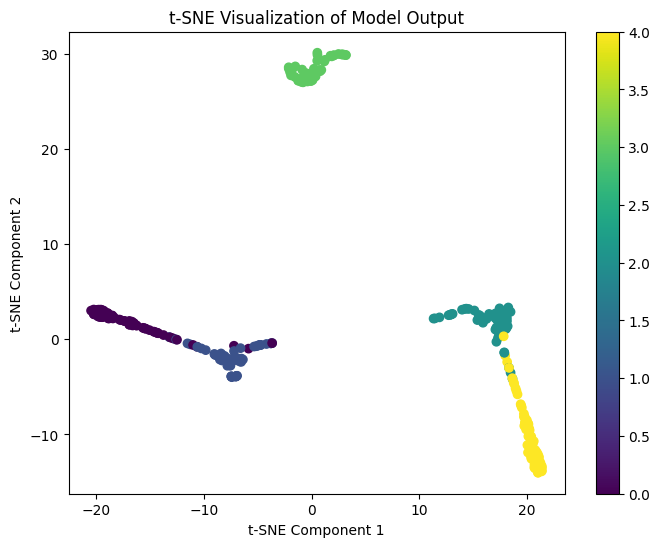

In [13]:
from sklearn.manifold import TSNE
output = anomaly_detector.test_outputs_tensors.cpu()
output = torch.squeeze(output)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
components = tsne.fit_transform(output)

labels = anomaly_detector.outputs_target
labels = torch.squeeze(labels)
labels = labels.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], cmap='viridis', c=labels)
plt.colorbar()
plt.title('t-SNE Visualization of Model Output')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [14]:
labels = anomaly_detector.outputs_target
labels = torch.squeeze(labels)
labels = labels.cpu().numpy()

preds = anomaly_detector.outputs_preds
preds = torch.squeeze(preds)
preds = preds.cpu().numpy()

print(f1_score(labels, preds, average='weighted'))
print(accuracy_score(labels, preds))

0.6929288439204155
0.7681159420289855


In [16]:
param_size = 0
for param in anomaly_detector.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in anomaly_detector.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 27.094MB


In [29]:
parameters_to_prune = (
    (anomaly_detector.model.model.conv1, 'weight'),
    (anomaly_detector.model.model.conv2, 'weight'),
    (anomaly_detector.model.model.conv3, 'weight'),
    (anomaly_detector.model.model.conv4, 'weight'),
    (anomaly_detector.model.model.fc1, 'weight'),
    (anomaly_detector.model.model.fc2, 'weight'),
    (anomaly_detector.model.model.fc3, 'weight'),
    (anomaly_detector.model.model.fc4, 'weight'),
    (anomaly_detector.model.model.conv1, 'bias'),
    (anomaly_detector.model.model.conv2, 'bias'),
    (anomaly_detector.model.model.conv3, 'bias'),
    (anomaly_detector.model.model.conv4, 'bias'),
    (anomaly_detector.model.model.fc1, 'bias'),
    (anomaly_detector.model.model.fc2, 'bias'),
    (anomaly_detector.model.model.fc3, 'bias'),
    (anomaly_detector.model.model.fc4, 'bias'),
)

In [30]:
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [31]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(anomaly_detector.model.model.conv1.weight == 0))
        / float(anomaly_detector.model.model.conv1.weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(anomaly_detector.model.model.conv2.weight == 0))
        / float(anomaly_detector.model.model.conv2.weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(anomaly_detector.model.model.conv3.weight == 0))
        / float(anomaly_detector.model.model.conv3.weight.nelement())
    )
)
print(
    "Sparsity in conv4.weight: {:.2f}%".format(
        100. * float(torch.sum(anomaly_detector.model.model.conv4.weight == 0))
        / float(anomaly_detector.model.model.conv4.weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(anomaly_detector.model.model.fc1.weight == 0))
        / float(anomaly_detector.model.model.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(anomaly_detector.model.model.fc2.weight == 0))
        / float(anomaly_detector.model.model.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(anomaly_detector.model.model.fc3.weight == 0))
        / float(anomaly_detector.model.model.fc3.weight.nelement())
    )
)
print(
    "Sparsity in fc4.weight: {:.2f}%".format(
        100. * float(torch.sum(anomaly_detector.model.model.fc4.weight == 0))
        / float(anomaly_detector.model.model.fc4.weight.nelement())
    )
)

Sparsity in conv1.weight: 1.39%
Sparsity in conv2.weight: 7.73%
Sparsity in conv3.weight: 18.42%
Sparsity in conv4.weight: 13.56%
Sparsity in fc1.weight: 20.17%
Sparsity in fc2.weight: 19.78%
Sparsity in fc3.weight: 10.86%
Sparsity in fc4.weight: 8.07%


In [32]:
trainer_detector = L.Trainer(
    max_epochs=1,
    # callbacks=[early_stopping_callback]
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
start = time.time()
trainer_detector.fit(anomaly_detector, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
print(time.time() - start)

In [34]:
for module in parameters_to_prune:
    prune.remove(module[0], module[1])

In [ ]:
start = time.time()
trainer_detector.test(anomaly_detector, dataloaders=test_dataloader)
print(time.time() - start)

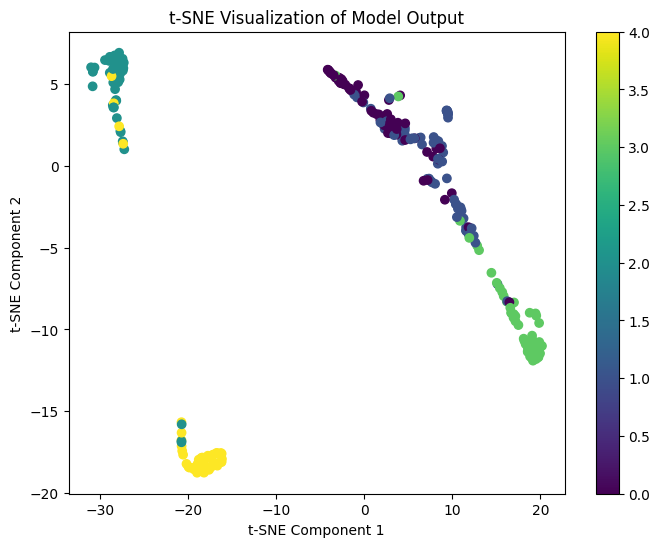

In [25]:
from sklearn.manifold import TSNE
output = anomaly_detector.test_outputs_tensors.cpu()
output = torch.squeeze(output)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
components = tsne.fit_transform(output)

labels = anomaly_detector.outputs_target
labels = torch.squeeze(labels)
labels = labels.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], cmap='viridis', c=labels)
plt.colorbar()
plt.title('t-SNE Visualization of Model Output')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [26]:
labels = anomaly_detector.outputs_target
labels = torch.squeeze(labels)
labels = labels.cpu().numpy()

preds = anomaly_detector.outputs_preds
preds = torch.squeeze(preds)
preds = preds.cpu().numpy()

print(f1_score(labels, preds, average='weighted'))
print(accuracy_score(labels, preds))

0.6212261178238591
0.7065217391304348


In [27]:
param_size = 0
for param in anomaly_detector.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in anomaly_detector.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 27.094MB


In [38]:
torch.save(anomaly_detector,'pruned.pt')

In [17]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile
  import tempfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [39]:
base_model_size = get_gzipped_model_size('referencja.pt')
pruned_model_size = get_gzipped_model_size('pruned.pt')

print("Rozmiar podstawowego modelu: %.2f bytes" % (base_model_size))
print("Rozmiar skompresowanego modelu: %.2f bytes" % (pruned_model_size))

print("Stopień kompresji = %f" %(base_model_size / pruned_model_size))

Rozmiar podstawowego modelu: 27153296.00 bytes
Rozmiar skompresowanego modelu: 22863788.00 bytes
Stopień kompresji = 1.187611


In [36]:
from torch.quantization import quantize_dynamic
model_quantized = quantize_dynamic(
    model=detector.to('cpu'), qconfig_spec={nn.Conv2d, nn.Linear}, dtype=torch.qint8, inplace=False
)

In [64]:
pruned_and_quant_model_size = get_gzipped_model_size('kwantyzacja.pt')

print("Rozmiar podstawowego modelu: %.2f bytes" % (base_model_size))
print("Rozmiar skompresowanego modelu: %.2f bytes" % (pruned_and_quant_model_size))

print("Stopień kompresji = %f" %(base_model_size / pruned_and_quant_model_size))

Rozmiar podstawowego modelu: 27153296.00 bytes
Rozmiar skompresowanego modelu: 5626979.00 bytes
Stopień kompresji = 4.825555


In [37]:
start = time.time()
score = []
outputs_tensors = []
outputs_preds = []
outputs_target = []
model_quantized.to('cpu')
for batch in test_dataloader:
    batch
    _, x1, x2, y1, y2, _, _= batch
    output, _ = model_quantized(x1)
    preds = torch.argmax(output,dim=1)
    target = torch.argmax(y1,dim=1)
    f1 = anomaly_detector.f1(preds, target)
    score.append(f1)
    outputs_tensors.append(output)
    outputs_preds.append(preds)
    outputs_target.append(target)
print(time.time() - start)

33.7252140045166


In [100]:
test_outputs = torch.stack(score)
test_outputs_tensors = torch.stack(outputs_tensors)
outputs_preds = torch.stack(outputs_preds)
outputs_target = torch.stack(outputs_target)

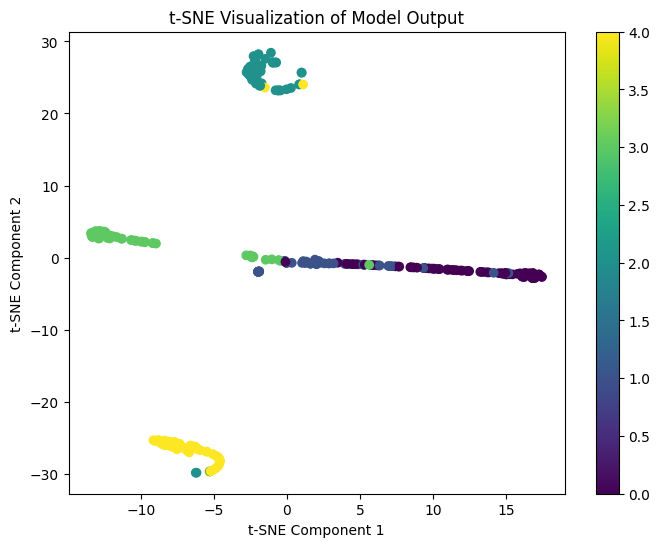

In [102]:
from sklearn.manifold import TSNE
output = test_outputs_tensors.cpu()
output = torch.squeeze(output)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
components = tsne.fit_transform(output)

labels = outputs_target
labels = torch.squeeze(labels)
labels = labels.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], cmap='viridis', c=labels)
plt.colorbar()
plt.title('t-SNE Visualization of Model Output')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [103]:
labels = outputs_target
labels = torch.squeeze(labels)
labels = labels.cpu().numpy()

preds = outputs_preds
preds = torch.squeeze(preds)
preds = preds.cpu().numpy()

print(f1_score(labels, preds, average='weighted'))
print(accuracy_score(labels, preds))

0.717018703384697
0.7789855072463768
